# Windrose plots
---  
*J. Michelle Hu  
University of Utah  
Nov 2024*  


In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

# sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
# import processing as proc

# Set seaborn palette
sns.set_palette('icefire')

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
basin = 'blue'

if basin == 'blue':
    elevation_bins = [2600, 2800, 3000, 3200, 3400, 3600, 3800, 4200]
    WY = '2019'
    sdd_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_sdd_shift_WY2019.nc'
elif basin == 'animas':
    WY = '2021'
    elevation_bins = [1900, 2200, 2500, 2800, 3100, 3400, 3700, 4000, 4300]
    sdd_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/animas_100m_isnobal/wy2021/animas_sdd_shift_WY2021.nc'
elif basin == 'yampa':
    WY = '2020'
    elevation_bins = [1900, 2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700]
    sdd_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/yampa_100m_isnobal/wy2020/yampa_sdd_shift_WY2020.nc'
else:
    raise ValueError(f'Basin not recognized: {basin}')

## Read in elevation and aspect

In [4]:
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts'
terrain_fn = h.fn_list(script_dir, f'{basin}*_setup/data/{basin}_terrain.nc')[0]
print(terrain_fn)
print(sdd_fn)

/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/data/blue_terrain.nc
/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_sdd_shift_WY2019.nc


## Generate combined dataset

In [5]:
# combine the two datasets
ds = xr.open_dataset(terrain_fn, drop_variables=['spatial_ref', 'hs', 'slope'])
ds
sdd_diff_ds = xr.open_dataset(sdd_fn)
# sdd_diff_ds
combo_ds = xr.merge([ds, sdd_diff_ds])
combo_ds

<xarray.Dataset> Size: 2MB
Dimensions:      (x: 428, y: 360)
Coordinates:
  * x            (x) float32 2kB 3.912e+05 3.913e+05 ... 4.338e+05 4.339e+05
  * y            (y) float32 1kB 4.392e+06 4.392e+06 ... 4.357e+06 4.356e+06
    spatial_ref  int64 8B ...
Data variables:
    dem          (y, x) float32 616kB ...
    aspect       (y, x) float32 616kB ...
    sdd_doy      (y, x) float64 1MB ...

In [ ]:
def plot_radial(combo_ds, elevation_bins=None, cmap=None, elev_fontcolor="black", title=None, vminnorm=-45, vmaxnorm=45, num_aspect_bins=16, aspect_labels=None):
    '''Need input for aspect_labels if num_aspect_bins is not 16
    TODO check where the aspec slice edges are 
    '''
    aspects = combo_ds['aspect'].values.flatten()
    elevation = combo_ds['dem'].values.flatten()
    peak_swe_shift = combo_ds['sdd_doy'].values.flatten()

    valid_data = ~np.isnan(peak_swe_shift) & ~np.isnan(elevation) & ~np.isnan(aspects)

    # Apply the valid data mask
    aspects = aspects[valid_data]
    elevation = elevation[valid_data]
    peak_swe_shift = peak_swe_shift[valid_data]

    # Step 1: Bin the aspect values into 16 bins (one for each direction)
    aspect_bins = np.linspace(0, num_aspect_bins, num_aspect_bins + 1).astype(int)  # 16 bins for aspect
    aspect_binned = np.digitize(aspects, aspect_bins) - 1  # 0-indexed bins

    # Step 2: Bin the elevation values using the custom bins
    if elevation_bins is None:
        # Equally spaced bins from minimum to maximum elevation rounded to the nearest 100
        binsize = 200
        steps = (round(elevation.max(), ndigits=-2) - round(elevation.min(), ndigits=-2)) / binsize
        elevation_bins = np.linspace(round(elevation.min(), ndigits=-2), round(elevation.max(), ndigits=-2), int(steps + 1))
    elevation_binned = np.digitize(elevation, elevation_bins) - 1  # 0-indexed bins
    # Number of bins
    num_elevation_bins = len(elevation_bins) - 1 # Based on custom elevation bins

    # Step 3: Aggregate peak_swe_shift by both aspect and elevation
    aggregated_values = []
    for aspect_bin in range(num_aspect_bins):
        for elev_bin in range(num_elevation_bins):  # Based on number of elevation intervals
            # Mask for the given aspect and elevation bin
            mask = (aspect_binned == aspect_bin) & (elevation_binned == elev_bin)
            valid_values = peak_swe_shift[mask]
            
            if len(valid_values) > 0:
                aggregated_values.append(np.mean(valid_values))
            else:
                aggregated_values.append(np.nan)

    aggregated_values = np.array(aggregated_values)

    # Step 4: Create a polar plot where the angle corresponds to aspect,
    # radius corresponds to reversed elevation bin, and color represents peak_swe_shift

    # Set up the polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6.5), dpi=300)
    # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8), dpi=300)
    # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))#, dpi=300)
    # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,4))#, dpi=300)

    # Angles for each aspect bin
    angles = np.linspace(0, 2 * np.pi, num_aspect_bins, endpoint=False)

    # Reverse the radius so higher elevations are at the center
    radius = np.linspace(1, 0.2, num_elevation_bins)  # Higher elevation closer to the center

    # Choose a color map and normalization
    # max_abs_value = max(abs(np.nanmin(aggregated_values)), abs(np.nanmax(aggregated_values)))

    # Set the color map and normalize with symmetric limits around 0
    # cmap = sns.palettes.color_palette('rocket', as_cmap=True)
    if cmap is None:
        # cmap = sns.diverging_palette(30, 250, s=100, l=100, center="light", as_cmap=True)
        cmap = sns.palettes.color_palette('rocket', as_cmap=True)
        # cmap = sns.palettes.color_palette('RdYlBu', as_cmap=True)
    norm = mcolors.Normalize(vmin=vminnorm, vmax=vmaxnorm)

    # Plot the radial bars without spaces between directions
    bar_width = 2 * np.pi / num_aspect_bins  # Full coverage per aspect

    for aspect_bin in range(num_aspect_bins):
        for elev_bin in range(num_elevation_bins):
            # Calculate the radius based on the reversed elevation bin
            r = radius[elev_bin]
            
            # Angle for this aspect bin
            theta = angles[aspect_bin]
            
            # Color based on the aggregated peak_swe_shift value
            color = cmap(norm(aggregated_values[aspect_bin * num_elevation_bins + elev_bin]))
            
            # Plot the bar at the correct angle and radius with no spacing
            ax.bar(theta, r, width=bar_width, bottom=0, color=color, alpha=0.8)

    # Adjust the orientation of the plot (rotate so North is at the top)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    # Calculate angles for the grid lines between directions
    half_bin_width = np.pi / num_aspect_bins  # Half-width to position grid lines between directions
    grid_angles = np.linspace(0, 2 * np.pi, num_aspect_bins, endpoint=False) + half_bin_width  # Boundary positions

    # Set grid lines at the boundaries between directions
    ax.set_xticks(grid_angles)  # Align grid lines between aspect bins

    # Define the angles for label placement at the center of each direction
    label_angles = np.linspace(0, 2 * np.pi, num_aspect_bins, endpoint=False)  # Center positions

    # Set labels for each direction only
    if num_aspect_bins == 16:
        aspect_labels = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 
                        'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

    ax.set_xticks(label_angles, labels=aspect_labels, size =11)  
    ax.grid(False)  # Turns off all grid lines
    # Set labels at centers without affecting grid lines

    # Optional: Customize grid line appearance for clarity
    #ax.grid(color='grey', linestyle='--', linewidth=0.5)  # Adjust style if desired


    # Reverse radius labels to match reversed elevation bins
    ax.set_yticks(radius)
    ax.set_yticklabels([f"{int(elev)} m" for elev in elevation_bins[:-1]], 
                    size=7, 
                    color=elev_fontcolor)  # Label each elevation bin
    ax.set_ylim(0, 1)

    # Add colorbar for peak_swe_shift values
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', pad=0.1)
    cbar.set_label('SDD shift (Days)')#, size=16)

    # Add title
    if title is None:
        title='Insert title here'
    ax.set_title(title, va='bottom');#, size=18)

    # # Show plot
    # plt.show()

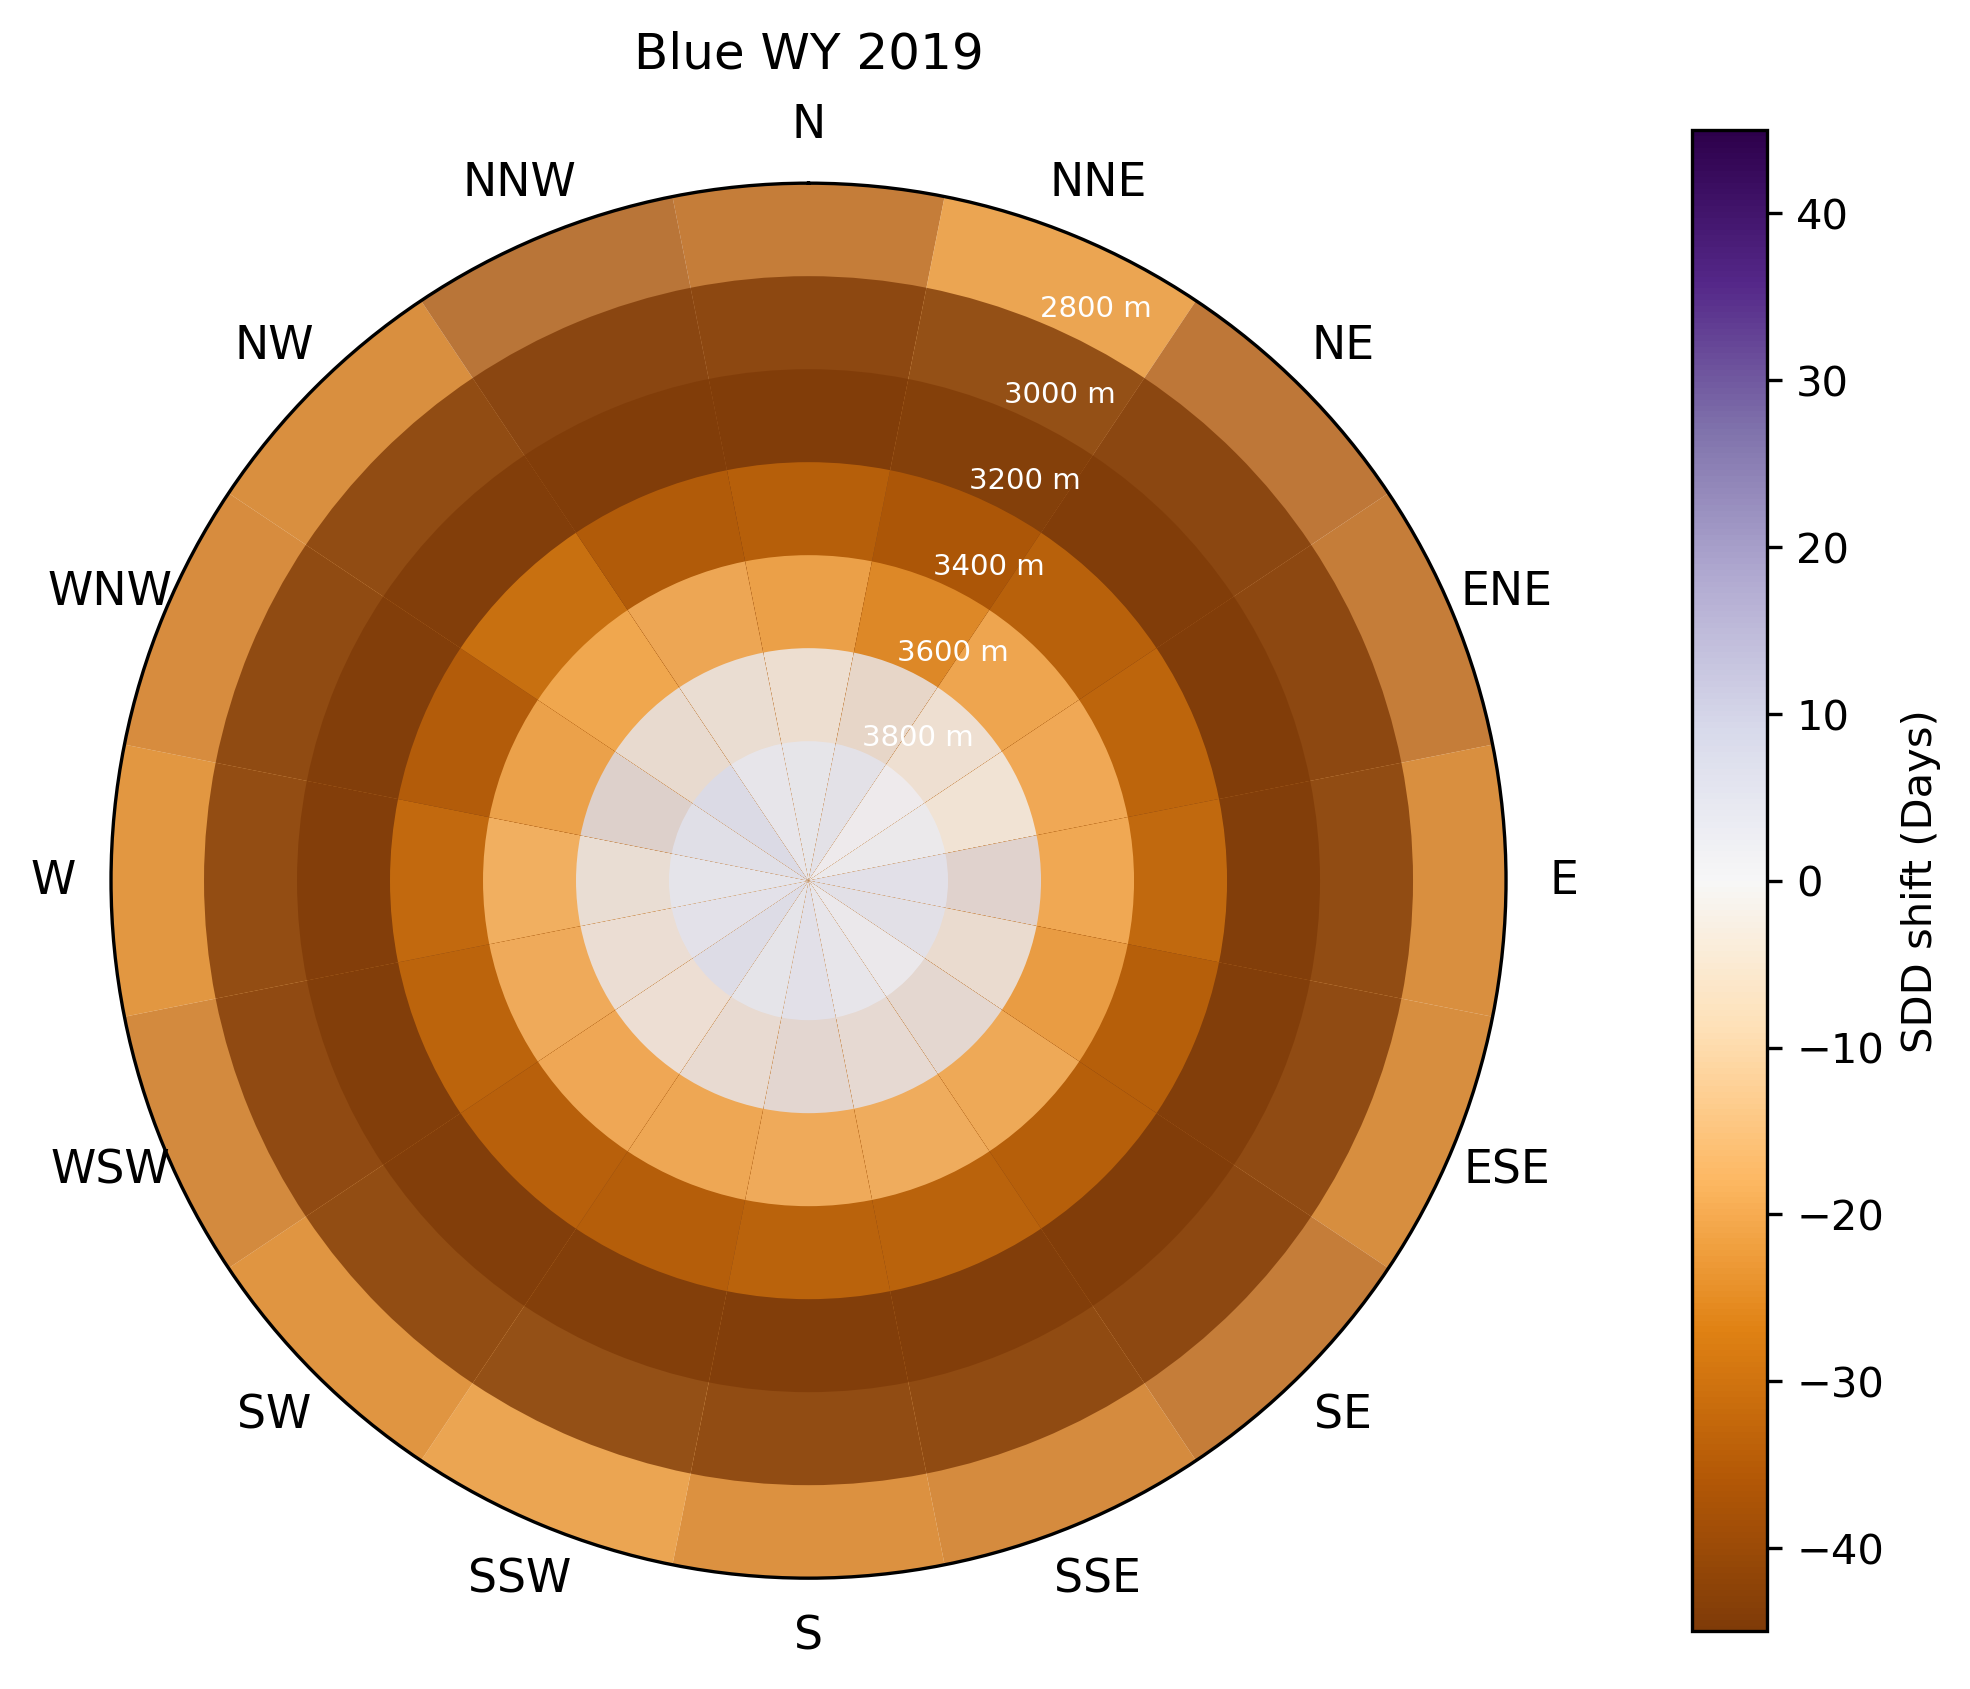

In [21]:
title = f'{basin.capitalize()} WY {WY}'
# cmap = sns.diverging_palette(30, 250, s=100, l=100, center="light", as_cmap=True)
# cmap = sns.palettes.color_palette('rocket', as_cmap=True)
# cmap = sns.palettes.color_palette('RdYlBu', as_cmap=True)
cmap = sns.palettes.color_palette('PuOr', as_cmap=True)
plot_radial(combo_ds=combo_ds, elevation_bins=elevation_bins, cmap=cmap, elev_fontcolor="white", title=title, vmaxnorm=45)


In [ ]:
# aspects = combo_ds['aspect'].values.flatten()
# elevation = combo_ds['dem'].values.flatten()
# peak_swe_shift = combo_ds['sdd_doy'].values.flatten()

# valid_data = ~np.isnan(peak_swe_shift) & ~np.isnan(elevation) & ~np.isnan(aspects)
# valid_data

# # Apply the valid data mask
# aspects = aspects[valid_data]
# elevation = elevation[valid_data]
# peak_swe_shift = peak_swe_shift[valid_data]

# # Step 1: Bin the aspect values into 16 bins (one for each direction)
# num_aspect_bins = 16
# aspect_bins = np.linspace(0, num_aspect_bins, num_aspect_bins + 1).astype(int)  # 16 bins for aspect
# aspect_binned = np.digitize(aspects, aspect_bins) - 1  # 0-indexed bins

# # Step 2: Bin the elevation values using the custom bins
# # Equally spaced bins from minimum to maximum elevation rounded to the nearest 100
# # binsize = 200
# # steps = (round(elevation.max(), ndigits=-2) - round(elevation.min(), ndigits=-2)) / binsize
# # elevation_bins = np.linspace(round(elevation.min(), ndigits=-2), round(elevation.max(), ndigits=-2), int(steps + 1))
# # elevation_bins = [1900, 2100, 2300, 2500, 2700, 2900, 3100, 3300, 3500, 3700, 3900, 4100, 4300]
# # elevation_bins = [1900, 2200, 2500, 2800, 3100, 3400, 3700, 4000, 4300]
# elevation_binned = np.digitize(elevation, elevation_bins) - 1  # 0-indexed bins
# # Number of bins
# # num_elevation_bins = int(steps)  
# num_elevation_bins = len(elevation_bins) - 1 # Based on custom elevation bins

# # Step 3: Aggregate peak_swe_shift by both aspect and elevation
# aggregated_values = []
# for aspect_bin in range(16):
#     for elev_bin in range(num_elevation_bins):  # Based on number of elevation intervals
#         # Mask for the given aspect and elevation bin
#         mask = (aspect_binned == aspect_bin) & (elevation_binned == elev_bin)
#         valid_values = peak_swe_shift[mask]
        
#         if len(valid_values) > 0:
#             aggregated_values.append(np.mean(valid_values))
#         else:
#             aggregated_values.append(np.nan)

# aggregated_values = np.array(aggregated_values)

# # Step 4: Create a polar plot where the angle corresponds to aspect,
# # radius corresponds to reversed elevation bin, and color represents peak_swe_shift

# # Set up the polar plot
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6.5), dpi=300)
# # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8), dpi=300)
# # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))#, dpi=300)
# # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,4))#, dpi=300)

# # Angles for each aspect bin
# angles = np.linspace(0, 2 * np.pi, num_aspect_bins, endpoint=False)

# # Reverse the radius so higher elevations are at the center
# radius = np.linspace(1, 0.2, num_elevation_bins)  # Higher elevation closer to the center

# # Choose a color map and normalization
# max_abs_value = max(abs(np.nanmin(aggregated_values)), abs(np.nanmax(aggregated_values)))

# # Set the color map and normalize with symmetric limits around 0
# # cmap = sns.palettes.color_palette('rocket', as_cmap=True)
# cmap = sns.diverging_palette(30, 250, s=100, l=100, center="light", as_cmap=True)
# # cmap = sns.palettes.color_palette('RdYlBu', as_cmap=True)
# norm = mcolors.Normalize(vmin=-45, vmax=45)

# # Plot the radial bars without spaces between directions
# bar_width = 2 * np.pi / num_aspect_bins  # Full coverage per aspect

# for aspect_bin in range(num_aspect_bins):
#     for elev_bin in range(num_elevation_bins):
#         # Calculate the radius based on the reversed elevation bin
#         r = radius[elev_bin]
        
#         # Angle for this aspect bin
#         theta = angles[aspect_bin]
        
#         # Color based on the aggregated peak_swe_shift value
#         color = cmap(norm(aggregated_values[aspect_bin * num_elevation_bins + elev_bin]))
        
#         # Plot the bar at the correct angle and radius with no spacing
#         ax.bar(theta, r, width=bar_width, bottom=0, color=color, alpha=0.8)

# # Adjust the orientation of the plot (rotate so North is at the top)
# ax.set_theta_zero_location('N')
# ax.set_theta_direction(-1)

# # Set labels to the cardinal directions
# aspect_map = {
#     0: 'N', 1: 'NNE', 2: 'NE', 3: 'ENE', 4: 'E', 5: 'ESE', 6: 'SE', 7: 'SSE',
#     8: 'S', 9: 'SSW', 10: 'SW', 11: 'WSW', 12: 'W', 13: 'WNW', 14: 'NW', 15: 'NNW'
# }

# #ax.set_xticks(angles)
# #ax.set_xticklabels(aspect_map.values())

# # Calculate angles for the grid lines between directions
# num_aspect_bins = 16
# half_bin_width = np.pi / num_aspect_bins  # Half-width to position grid lines between directions
# grid_angles = np.linspace(0, 2 * np.pi, num_aspect_bins, endpoint=False) + half_bin_width  # Boundary positions

# # Set grid lines at the boundaries between directions
# ax.set_xticks(grid_angles)  # Align grid lines between aspect bins

# # Define the angles for label placement at the center of each direction
# label_angles = np.linspace(0, 2 * np.pi, num_aspect_bins, endpoint=False)  # Center positions

# # Set labels for each direction only
# aspect_labels = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 
#                  'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

# ax.set_xticks(label_angles, labels=aspect_labels, size =11)  
# ax.grid(False)  # Turns off all grid lines
# # Set labels at centers without affecting grid lines

# # Optional: Customize grid line appearance for clarity
# #ax.grid(color='grey', linestyle='--', linewidth=0.5)  # Adjust style if desired


# # Reverse radius labels to match reversed elevation bins
# ax.set_yticks(radius)
# ax.set_yticklabels([f"{int(elev)} m" for elev in elevation_bins[:-1]], 
#                    size=7, 
#                    color="black")  # Label each elevation bin
# ax.set_ylim(0, 1)

# # Add colorbar for peak_swe_shift values
# cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', pad=0.1)
# cbar.set_label('SDD shift (Days)')#, size=16)


# # Add title
# ax.set_title(f'{basin.capitalize()} WY {WY}', va='bottom');#, size=18)

# # # Show plot
# # plt.show()